#### Classify model from Yu, et al
Implementation of the classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Difference(s) from paper:
- Run for 30 epochs instead of 80
- Resized to 60x60 with 3x3 median filter applied

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# specify variables for model
path = 'processed_data/WM-clean60-mfilter3'
result_path = 'results'
model_path = '../saved_models'

filename = 'WM-clean60-mfilter3'
option = '-classify' # -classify, -knn
map_column = 'waferMap60'

model_id = 'yuclassify'
data_id = '60'
note = '-mfilter3' # -optional

In [6]:
# load train, dev, and test sets
# directly from S3 (using boto3 resource)
start = time.time()

train_key = f'{path}/{filename}-train{option}.pkl'
dev_key = f'{path}/{filename}-dev.pkl'
test_key = f'{path}/{filename}-test.pkl'

train = pickle.loads(my_bucket.Object(train_key).get()['Body'].read())
dev = pickle.loads(my_bucket.Object(dev_key).get()['Body'].read())
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

# remove nones from dev and test

dev = dev[dev.classifyLabels != 8].reset_index(drop=True)
test = test[test.classifyLabels != 8].reset_index(drop=True)

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

print(f"Sanity check: {np.unique(train[map_column][0])}")

Wall time: 3.58 seconds
Train: 17863
Dev: 3828
Test: 3828
Sanity check: [0 1 2]


#### Quick EDA

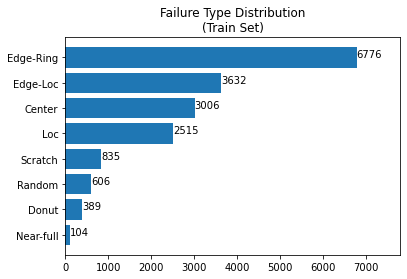

In [7]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

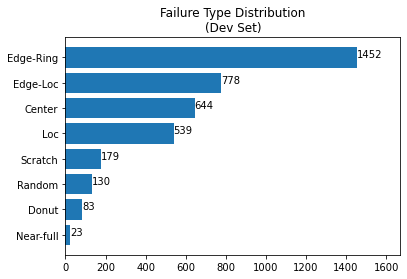

In [8]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

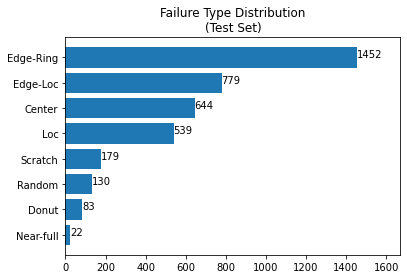

In [9]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [10]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: (#rows, xdim, ydim)
print(x_train.shape)

Wall time: 0.06 seconds
(17863, 60, 60)


In [11]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

Wall time: 0.97 seconds


TensorShape([17863, 60, 60, 1])

In [12]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = np.asarray(train['classifyLabels']).astype(np.uint8)
y_val = np.asarray(dev['classifyLabels']).astype(np.uint8)
y_test = np.asarray(test['classifyLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 7
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.00 seconds
<class 'numpy.uint8'>
0 0 0
7 7 7


#### Model

In [13]:
# define model architecture

model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./2., input_shape=x_train.shape[1:]))
model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation='nearest'))
model.add(layers.experimental.preprocessing.RandomFlip(seed=424))
model.add(layers.experimental.preprocessing.RandomRotation(1, fill_mode='constant', interpolation='nearest', seed=424))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 60, 60, 1)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 60, 60, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        1

In [14]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [15]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=30)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Epoch 1/30
140/140 [==============================] - 4s 30ms/step - loss: 1.4959 - accuracy: 0.4945 - val_loss: 0.7206 - val_accuracy: 0.7307
Epoch 2/30
140/140 [==============================] - 4s 27ms/step - loss: 0.6430 - accuracy: 0.7672 - val_loss: 0.5273 - val_accuracy: 0.7965
Epoch 3/30
140/140 [==============================] - 4s 27ms/step - loss: 0.5142 - accuracy: 0.8127 - val_loss: 0.4350 - val_accuracy: 0.8370
Epoch 4/30
140/140 [==============================] - 4s 27ms/step - loss: 0.4526 - accuracy: 0.8345 - val_loss: 0.3799 - val_accuracy: 0.8537
Epoch 5/30
140/140 [==============================] - 4s 27ms/step - loss: 0.4114 - accuracy: 0.8497 - val_loss: 0.3845 - val_accuracy: 0.8542
Epoch 6/30
140/140 [==============================] - 4s 27ms/step - loss: 0.3810 - accuracy: 0.8574 - val_loss: 0.3767 - val_accuracy: 0.8592
Epoch 7/30
140/140 [==============================] - 4s 27ms/step - loss: 0.3711 - accuracy: 0.8645 - val_loss: 0.3578 - val_accuracy: 0.8691

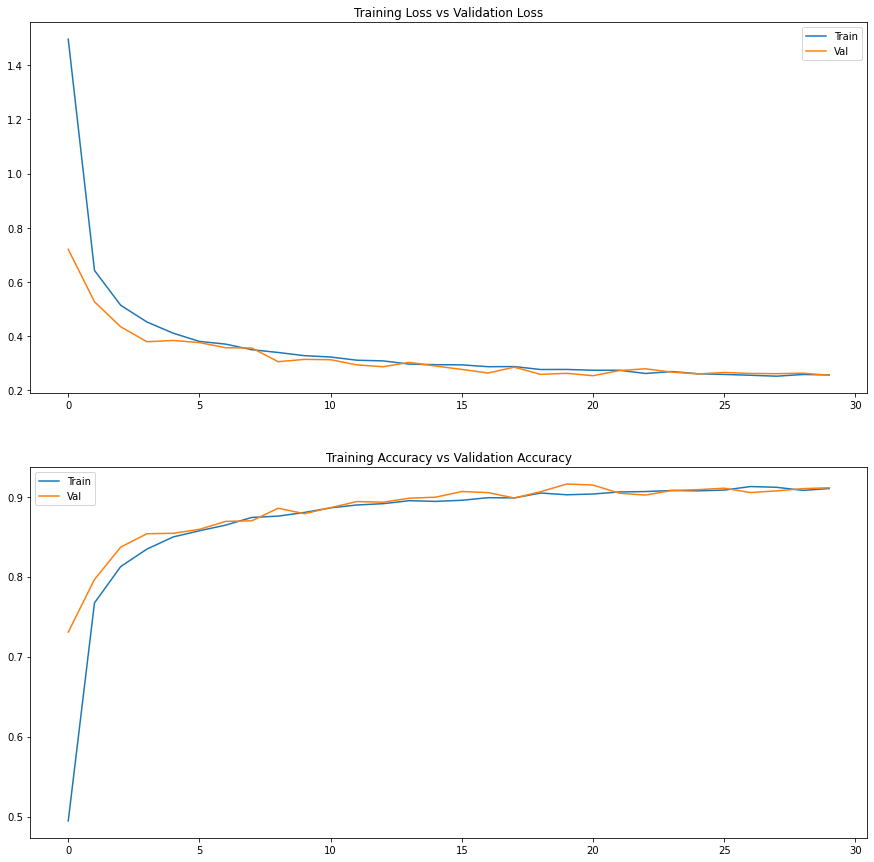

In [16]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [17]:
# # save model to local instance
# model.save(f'{model_path}/{model_id}-{data_id}{note}')

In [18]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpct2douve/yuclassify-60-mfilter3/assets


In [19]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

120/120 [==============================] - 0s 4ms/step - loss: 0.2579 - accuracy: 0.9083
Wall time: 0.54 seconds
[0.2578822672367096, 0.9083071947097778]


In [20]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 0.34 seconds


In [21]:
# save predictions to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

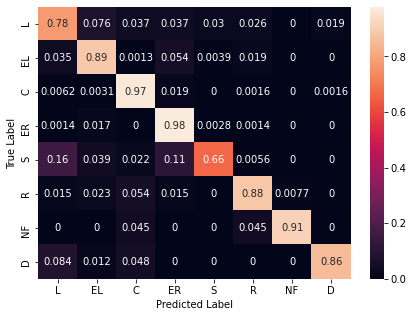

In [22]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='classify', normalize=True)

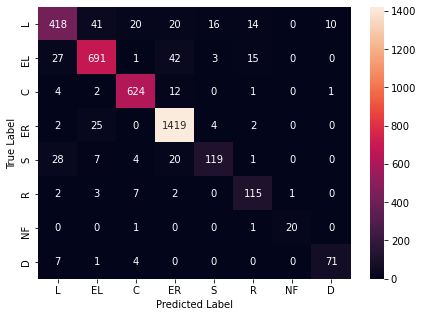

In [23]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='classify', normalize=False)